# Выявление закономерностей и причин выгорания сотрудников

## Загрузка библиотек и датасета

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as catb
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display

In [2]:
pd.options.display.max_columns = None

In [ ]:
data_path = './data/hr_data.xlsx'

In [4]:
orig_data = pd.read_excel(data_path, 'HR-Employee-Info')
orig_data.sample(10)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1047,19,Yes,Travel_Rarely,489,Human Resources,2,2,Technical Degree,566,1,Male,52,2,1,Human Resources,4,Single,2564,18437,1,Y,No,12,3,3,80,0,1,3,4,1,0,0,0
30,36,No,Travel_Rarely,557,Sales,3,3,Medical,2024,1,Female,94,2,3,Sales Executive,4,Married,7644,12695,0,Y,No,19,3,3,80,2,10,2,3,9,7,3,4
788,38,No,Travel_Rarely,1333,Research & Development,1,3,Technical Degree,950,4,Female,80,3,3,Research Director,1,Married,13582,16292,1,Y,No,13,3,2,80,1,15,3,3,15,12,5,11
688,26,No,Travel_Rarely,192,Research & Development,1,2,Medical,1083,1,Male,59,2,1,Laboratory Technician,1,Married,3955,11141,1,Y,No,16,3,1,80,2,6,2,3,5,3,1,3
754,33,No,Travel_Frequently,827,Research & Development,1,4,Other,998,3,Female,84,4,2,Healthcare Representative,2,Married,5488,20161,1,Y,Yes,13,3,1,80,1,6,2,3,6,5,1,2
919,23,No,Travel_Rarely,650,Research & Development,9,1,Medical,758,2,Male,37,3,1,Laboratory Technician,1,Married,2500,4344,1,Y,No,14,3,4,80,1,5,2,4,4,3,0,2
261,34,No,Travel_Rarely,1157,Research & Development,5,2,Medical,1696,2,Male,57,2,2,Laboratory Technician,4,Married,3986,11912,1,Y,No,14,3,3,80,1,15,3,4,15,10,4,13
532,39,No,Travel_Rarely,412,Research & Development,13,4,Medical,1307,3,Female,94,2,4,Manager,2,Divorced,17123,17334,6,Y,Yes,13,3,4,80,2,21,4,3,19,9,15,2
640,33,Yes,Travel_Rarely,603,Sales,9,4,Marketing,1157,1,Female,77,3,2,Sales Executive,1,Single,8224,18385,0,Y,Yes,17,3,1,80,0,6,3,3,5,2,0,3
12,40,No,Travel_Rarely,1194,Research & Development,2,4,Medical,2051,3,Female,98,3,1,Research Scientist,3,Married,2001,12549,2,Y,No,14,3,2,80,3,20,2,3,5,3,0,2


In [5]:
orig_data.shape

(1470, 34)

## Предобработка датасета

In [6]:
data = orig_data.copy(deep=True)

In [7]:
data.isna().sum().sum()

0

В датасете нет пропущенных данных

Проверим количество уникальных значений

In [8]:
data.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCom

In [9]:
data.shape

(1470, 34)

Значения EmployeeNumber являются идентификаторами сотрдуников (количество уникальных значений соответствует количеству сотрудников в датасете), поэтому их можно опустить

In [10]:
data.drop('EmployeeNumber', axis=1, inplace=True) 

Также опустим столбцы, в которых имеется только одно уникальное значение

In [11]:
def drop_mono(df):
    dropped = list(df.columns[df.nunique() < 2])
    df.drop(dropped, axis=1, inplace=True)
    return dropped

In [12]:
dropped = drop_mono(data)
dropped

['Over18', 'StandardHours']

* Все сотрудники являются соверешеннолетними, а также все работают одинаковое количество часов (80)

Переведем признаки, представленные в текстовом формате, в числовой формат

In [13]:
def encode_df(df):
    codes = dict()
    for i, val_type in enumerate(df.dtypes):
        if val_type == object:
            inCategories = df[df.columns[i]].astype('category')
            codes[df.columns[i]] = dict(enumerate(inCategories.cat.categories))
            df[df.columns[i]] = inCategories.cat.codes
    return codes

In [14]:
codes = encode_df(data)

Отобразим таблицу кодировки

In [15]:
pd.DataFrame.from_dict(codes).fillna('')

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
0,No,Non-Travel,Human Resources,Human Resources,Female,Healthcare Representative,Divorced,No
1,Yes,Travel_Frequently,Research & Development,Life Sciences,Male,Human Resources,Married,Yes
2,,Travel_Rarely,Sales,Marketing,,Laboratory Technician,Single,
3,,,,Medical,,Manager,,
4,,,,Other,,Manufacturing Director,,
5,,,,Technical Degree,,Research Director,,
6,,,,,,Research Scientist,,
7,,,,,,Sales Executive,,
8,,,,,,Sales Representative,,


Получим примеры данных после обработки

In [16]:
data.sample(10)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1039,35,0,2,144,1,22,3,1,4,1,46,1,1,2,3,2,4230,19225,0,0,15,3,3,0,6,2,3,5,4,4,3
1069,39,0,1,1218,1,1,1,1,2,1,52,3,5,3,3,0,19197,8213,1,1,14,3,3,1,21,3,3,21,8,1,6
843,32,0,2,638,1,8,2,3,3,0,91,4,2,6,3,1,5175,22162,5,0,12,3,3,1,9,3,2,5,3,1,3
636,27,0,2,199,1,6,3,1,4,1,55,2,1,6,3,1,2539,7950,1,0,13,3,3,1,4,0,3,4,2,2,2
1214,25,0,2,685,1,1,3,1,1,0,62,3,2,4,3,1,4898,7505,0,0,12,3,4,2,5,3,3,4,2,1,2
229,39,0,0,792,1,1,3,1,4,1,77,3,2,2,4,1,6472,8989,1,1,15,3,4,1,9,2,3,9,8,5,8
1252,29,1,2,992,1,1,3,5,3,1,85,3,1,6,3,2,2058,19757,0,0,14,3,4,0,7,1,2,6,2,1,5
550,59,0,2,1429,1,18,4,3,4,1,67,3,3,4,4,2,10512,20002,6,0,12,3,4,0,25,6,2,9,7,5,4
18,38,0,2,345,2,10,2,1,1,0,100,3,2,7,4,1,5343,5982,1,0,11,3,3,1,10,1,3,10,7,1,9
245,26,0,2,390,1,17,4,3,4,1,62,1,1,2,3,1,2305,6217,1,0,15,3,3,3,3,3,4,3,2,0,2


## Общий анализ и выявление закономерностей

In [17]:
data.describe().round(2)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00,1470.00
mean,36.92,0.16,1.61,802.49,1.26,9.19,2.91,2.25,2.72,0.60,65.89,2.73,2.06,4.46,2.73,1.10,6502.93,14313.10,2.69,0.28,15.21,3.15,2.71,0.79,11.28,2.80,2.76,7.01,4.23,2.19,4.12
std,9.14,0.37,0.67,403.51,0.53,8.11,1.02,1.33,1.09,0.49,20.33,0.71,1.11,2.46,1.10,0.73,4707.96,7117.79,2.50,0.45,3.66,0.36,1.08,0.85,7.78,1.29,0.71,6.13,3.62,3.22,3.57
min,18.00,0.00,0.00,102.00,0.00,1.00,1.00,0.00,1.00,0.00,30.00,1.00,1.00,0.00,1.00,0.00,1009.00,2094.00,0.00,0.00,11.00,3.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
25%,30.00,0.00,1.00,465.00,1.00,2.00,2.00,1.00,2.00,0.00,48.00,2.00,1.00,2.00,2.00,1.00,2911.00,8047.00,1.00,0.00,12.00,3.00,2.00,0.00,6.00,2.00,2.00,3.00,2.00,0.00,2.00
50%,36.00,0.00,2.00,802.00,1.00,7.00,3.00,2.00,3.00,1.00,66.00,3.00,2.00,5.00,3.00,1.00,4919.00,14235.50,2.00,0.00,14.00,3.00,3.00,1.00,10.00,3.00,3.00,5.00,3.00,1.00,3.00
75%,43.00,0.00,2.00,1157.00,2.00,14.00,4.00,3.00,4.00,1.00,83.75,3.00,3.00,7.00,4.00,2.00,8379.00,20461.50,4.00,1.00,18.00,3.00,4.00,1.00,15.00,3.00,3.00,9.00,7.00,3.00,7.00
max,60.00,1.00,2.00,1499.00,2.00,29.00,5.00,5.00,4.00,1.00,100.00,4.00,5.00,8.00,4.00,2.00,19999.00,26999.00,9.00,1.00,25.00,4.00,4.00,3.00,40.00,6.00,4.00,40.00,18.00,15.00,17.00


Выводы из общей статистики:
* Средний возраст сотрудников: ~37 лет (от 18 до 60 лет)
* "Истощенные" сотрудники составляют 16%
* Среди сотрудников мужчин на 20% больше, чем женщин
* На данный момент сотрудники компании работают в ней на протяжении 7 лет в среднем (медиана - 5 лет), причем наиболее продолжительный срок - 40 лет
* 28% сотрудников перерабатывают
* Средний месячный доход составляет ~6503 (медиана - 4619) (от 1009 до 19999)
* Продуктивность (PerformanceRating) представлена только в 2 вариантах (3 - Excellent и 4 - Outstanding)

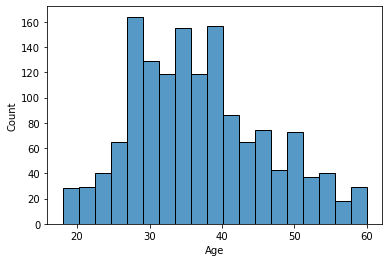

In [18]:
sns.histplot(data=data, x='Age')
plt.show()

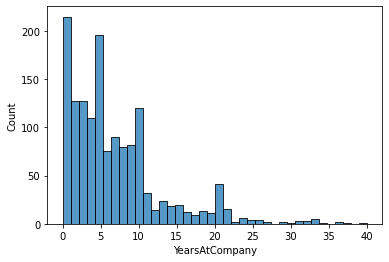

In [19]:
sns.histplot(data=data, x='YearsAtCompany')
plt.show()

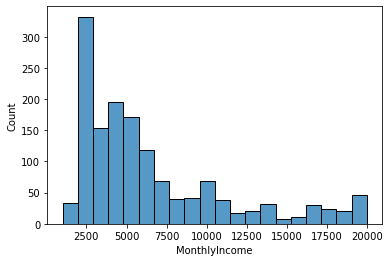

In [20]:
sns.histplot(data=data, x='MonthlyIncome')
plt.show()

### Анализ корреляций между признаками

Отобразим матрицу корреляций факторов

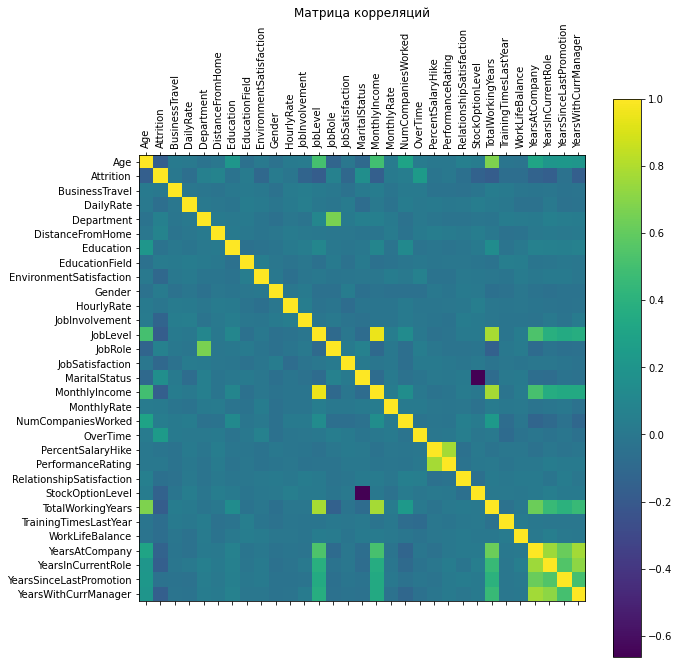

In [21]:
cor = data.corr()
plt.matshow(cor, plt.figure(figsize=(10, 10)).number)
plt.xticks(range(cor.shape[0]), data.columns, rotation=90)
plt.yticks(range(cor.shape[1]), data.columns)
cb = plt.colorbar()
plt.title('Матрица корреляций')
plt.show()

Определим сильно коррелирующие признаки (коэффициент корреляции больше 0.6)

In [22]:
coef_cor = 0.6
cor_entities = dict()
cor_df = cor.abs() > coef_cor
for entity in cor_df.columns:
    cor_list = [(cor_entity,round(cor[entity][cor_entity], 2)) 
                for cor_entity in cor_df[cor_df[entity]].index 
                if cor_entity != entity]
    if len(cor_list) > 0:
        cor_entities[entity] = cor_list 
cor_entities

{'Age': [('TotalWorkingYears', 0.68)],
 'Department': [('JobRole', 0.66)],
 'JobLevel': [('MonthlyIncome', 0.95), ('TotalWorkingYears', 0.78)],
 'JobRole': [('Department', 0.66)],
 'MaritalStatus': [('StockOptionLevel', -0.66)],
 'MonthlyIncome': [('JobLevel', 0.95), ('TotalWorkingYears', 0.77)],
 'PercentSalaryHike': [('PerformanceRating', 0.77)],
 'PerformanceRating': [('PercentSalaryHike', 0.77)],
 'StockOptionLevel': [('MaritalStatus', -0.66)],
 'TotalWorkingYears': [('Age', 0.68),
  ('JobLevel', 0.78),
  ('MonthlyIncome', 0.77),
  ('YearsAtCompany', 0.63)],
 'YearsAtCompany': [('TotalWorkingYears', 0.63),
  ('YearsInCurrentRole', 0.76),
  ('YearsSinceLastPromotion', 0.62),
  ('YearsWithCurrManager', 0.77)],
 'YearsInCurrentRole': [('YearsAtCompany', 0.76),
  ('YearsWithCurrManager', 0.71)],
 'YearsSinceLastPromotion': [('YearsAtCompany', 0.62)],
 'YearsWithCurrManager': [('YearsAtCompany', 0.77),
  ('YearsInCurrentRole', 0.71)]}

Выводы из корреляций:
* Продуктивность (PerformanceRating) сильно коррелирует с процентами повышения зарплаты (PercentSalaryHike), что может быть как следствием, так и причиной (на основании датасета нельзя сделать точный вывод) 
* Уровень должности (JobLevel) сильно коррелирует с общим стажем (TotalWorkingYears), но не с количеством лет, проработанных в компании (YearsAtCompany)
* Месячный доход (MonthlyIncome) почти напрямую зависит от уровня должности (JobLevel)

*Корреляция StockOptionLevel и MaritalStatus опущена, так как второй признак категориальный, закодированный в числовом формате - проверим отдельно*

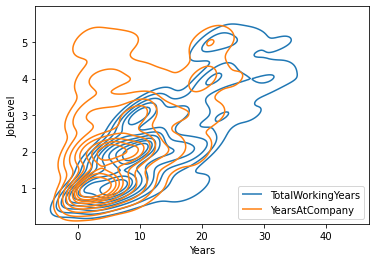

In [23]:
sns.kdeplot(x=data['TotalWorkingYears'], y=data['JobLevel'], label='TotalWorkingYears')
sns.kdeplot(x=data['YearsAtCompany'], y=data['JobLevel'], label='YearsAtCompany')
plt.legend(loc='lower right')
plt.xlabel('Years')
plt.show()

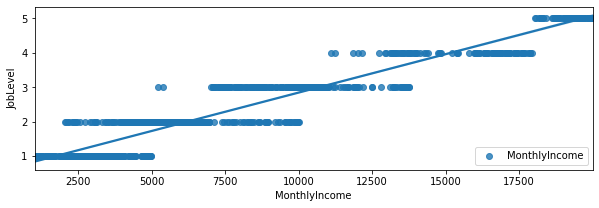

In [24]:
plt.figure(figsize=(10, 3))
sns.regplot(x=data['MonthlyIncome'], y=data['JobLevel'], label='MonthlyIncome')
plt.legend(loc='lower right')
plt.show()

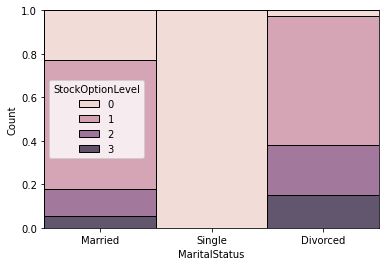

In [25]:
sns.histplot(data=orig_data, x='MaritalStatus', hue="StockOptionLevel", multiple="fill")
plt.show()

* Все Single сотрудники имеют нулевой уровень опциона эмитента (StockOptionLevel)
* Уровень опциона эмитента выше у разведенных сотрудников, чем у находящихся в браке

### Аспект переработок (OverTime)

Нормализуем данные и проверим отклонения средних

In [26]:
norm_data = (data - data.min()) / (data.max() - data.min())
norm_data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.380952,0.0,1.0,0.376521,0.5,0.250000,0.50,0.6,0.333333,1.0,0.742857,1.000000,0.25,0.250,0.666667,0.5,0.178778,0.326601,0.222222,0.0,0.071429,0.0,0.000000,0.000000,0.150,0.500000,1.000000,0.100,0.166667,0.066667,0.117647
1,0.738095,0.0,0.5,0.659270,1.0,0.035714,0.50,0.6,1.000000,1.0,0.471429,0.333333,0.25,0.875,0.333333,0.5,0.230700,0.447661,0.222222,0.0,0.214286,0.0,1.000000,0.000000,0.425,0.500000,0.333333,0.225,0.333333,0.000000,0.470588
2,0.214286,0.0,1.0,0.037938,0.5,0.107143,0.50,0.2,0.333333,1.0,0.814286,1.000000,0.25,0.500,0.333333,0.5,0.270300,0.123670,0.111111,1.0,0.642857,1.0,0.333333,0.333333,0.150,0.000000,0.666667,0.150,0.111111,0.000000,0.176471
3,0.500000,0.0,1.0,0.365784,0.5,0.178571,0.00,0.6,1.000000,1.0,0.171429,0.333333,0.50,0.000,0.000000,0.5,0.472986,0.777474,0.444444,0.0,0.285714,0.0,0.000000,0.333333,0.225,0.833333,0.666667,0.175,0.388889,0.066667,0.411765
4,0.428571,0.0,0.5,0.559771,0.5,0.785714,0.25,0.6,0.666667,1.0,0.157143,1.000000,0.25,0.250,1.000000,0.5,0.082254,0.409396,0.444444,0.0,0.428571,0.0,0.666667,0.333333,0.425,0.500000,0.666667,0.125,0.111111,0.000000,0.176471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0.214286,0.0,1.0,0.350036,0.5,0.035714,0.00,0.6,0.000000,1.0,0.142857,0.666667,0.00,0.250,0.333333,0.5,0.129489,0.583738,1.000000,0.0,0.071429,0.0,1.000000,0.333333,0.150,0.500000,0.666667,0.050,0.111111,0.133333,0.117647
1466,0.357143,0.0,0.5,0.923407,0.5,0.071429,0.75,0.2,1.000000,0.0,0.371429,0.666667,0.00,0.750,0.666667,0.5,0.100053,0.845814,0.111111,1.0,0.000000,0.0,0.666667,0.000000,0.200,0.500000,0.666667,0.200,0.388889,0.200000,0.000000
1467,0.452381,1.0,1.0,0.909807,0.5,0.035714,0.25,0.8,1.000000,1.0,0.885714,0.333333,0.00,0.250,0.666667,1.0,0.056925,0.012126,0.666667,1.0,0.285714,0.0,0.333333,0.000000,0.175,0.500000,0.666667,0.000,0.000000,0.000000,0.000000
1468,0.738095,0.0,0.5,0.126700,0.5,0.250000,0.00,0.2,0.666667,1.0,0.442857,0.333333,0.25,0.750,0.333333,0.5,0.217009,0.916001,0.111111,0.0,0.857143,1.0,1.000000,0.333333,0.250,0.500000,0.666667,0.250,0.388889,0.066667,0.411765


In [27]:
(norm_data[norm_data['OverTime'] == 1].mean() - norm_data[norm_data['OverTime'] == 0].mean()).to_frame('Mean difference').round(3)

,Mean difference
Age,0.014
Attrition,0.201
BusinessTravel,0.012
DailyRate,0.006
Department,0.004
DistanceFromHome,0.016
Education,-0.012
EducationField,0.001
EnvironmentSatisfaction,0.057
Gender,-0.046


* Переработки (OverTime) практически не влияют на среднюю продуктивность (PerformanceRating) среди сотрудников и на их средний месячный доход (MonthlyIncome)
* Переработки увеличивают факт истощения (Attrition)
* При этом среднее значение удовлетворенности работой (JobSatisfaction) почти не меняется (а даже незначительно возрастает при наличии переработок)

Покажем это на графиках

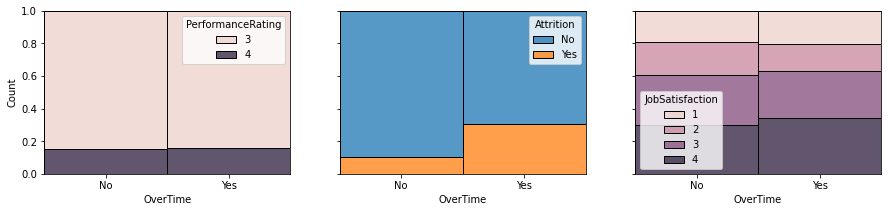

In [28]:
grid, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
sns.histplot(ax=axes[0], data=orig_data, x='OverTime', hue="PerformanceRating", multiple="fill")
sns.histplot(ax=axes[1], data=orig_data, x='OverTime', hue="Attrition", multiple="fill")
sns.histplot(ax=axes[2], data=orig_data, x='OverTime', hue="JobSatisfaction", multiple="fill")
plt.show()

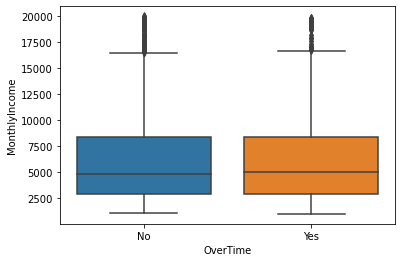

In [29]:
sns.boxplot(data=orig_data, x='OverTime', y='MonthlyIncome')
plt.show()

* Интересным является тот факт, что имеются сильные выбросы в ежемесячном доходе сотрудников. Рассмотрим его подробнее

### Аспект ежемесячного дохода сотрудников (MonthlyIncome)

Рассмотрим данный аспект в зависимости от уровня должности (JobLevel)

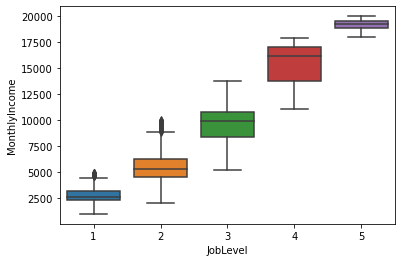

In [30]:
sns.boxplot(data=data, x='JobLevel', y='MonthlyIncome')
plt.show()

* Заметны сильные выбросы у сотрудников 1 и 2 уровней

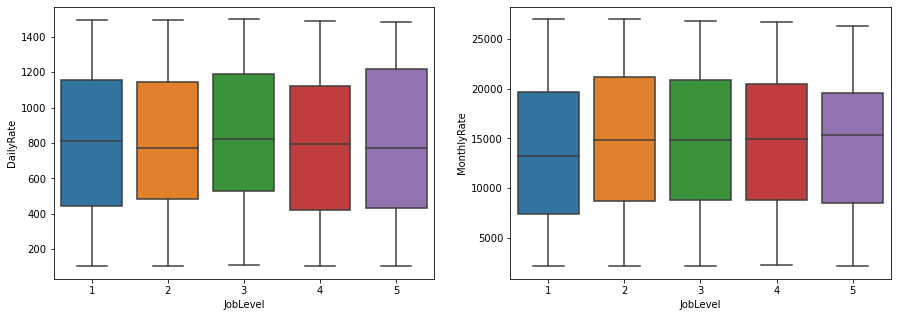

In [31]:
grid, axes = plt.subplots(1,2, figsize=(15, 5))
sns.boxplot(ax=axes[0], data=data, x='JobLevel', y='DailyRate')
sns.boxplot(ax=axes[1], data=data, x='JobLevel', y='MonthlyRate')
plt.show()

При этом в ставках DailyRate и MonthlyRate выбросы отсутствуют, однако странно, что нет роста с увеличением уровня должности (JobLevel)

Сравним распределение по должностям 30 сотрудников с наивысшим показателем ежемесячного дохода и 30 с наименьшим

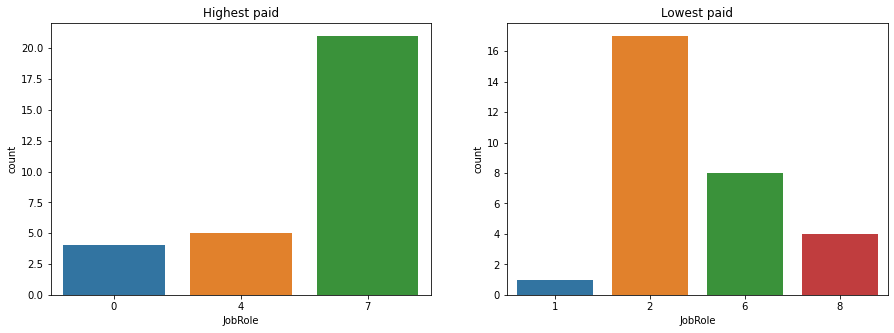

In [32]:
hp_data = data[data['JobLevel'] == 2].nlargest(30, 'MonthlyIncome')
lp_data = data[data['JobLevel'] == 2].nsmallest(30, 'MonthlyIncome')
grid, axes = plt.subplots(1,2, figsize=(15, 5))
sns.countplot(ax = axes[0], data=hp_data, x='JobRole')
axes[0].set_title('Highest paid')
sns.countplot(ax = axes[1], data=lp_data, x='JobRole')
axes[1].set_title('Lowest paid')
plt.show()

* Заметно, что для сотрудников с уровнем должности (JobLevel), равным 2, различие состоит в наборе занимаемых позиций (JobRole)

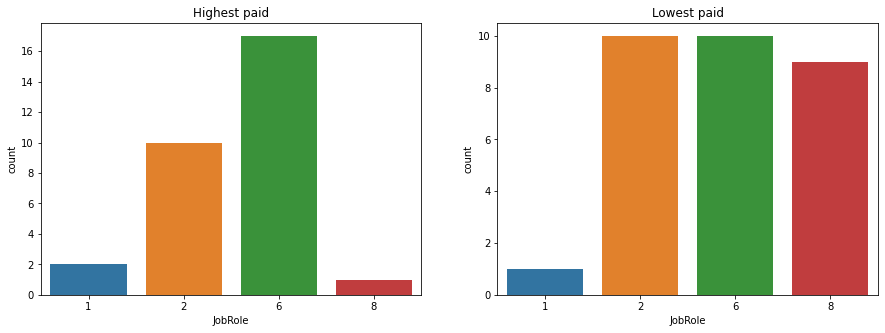

In [33]:
hp_data = data[data['JobLevel'] == 1].nlargest(30, 'MonthlyIncome')
lp_data = data[data['JobLevel'] == 1].nsmallest(30, 'MonthlyIncome')
grid, axes = plt.subplots(1,2, figsize=(15, 5))
sns.countplot(ax=axes[0], data=hp_data, x='JobRole')
axes[0].set_title('Highest paid')
sns.countplot(ax=axes[1], data=lp_data, x='JobRole')
axes[1].set_title('Lowest paid')
plt.show()

Однако для сотрудников с уровнем должности (JobLevel), равным 1, данного различия нет

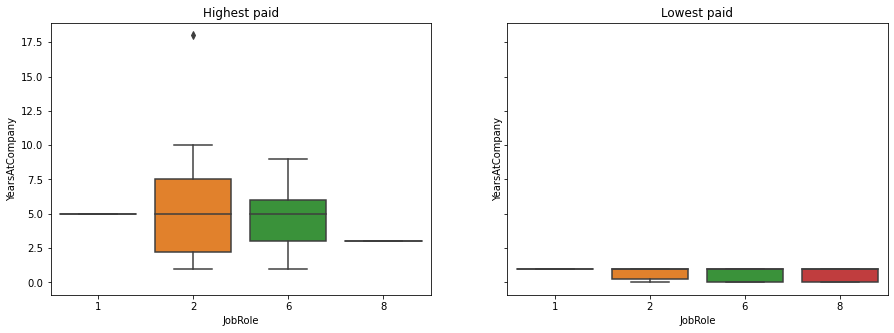

In [34]:
grid, axes = plt.subplots(1,2, figsize=(15, 5), sharey=True)
sns.boxplot(ax=axes[0], data=hp_data, x='JobRole', y='YearsAtCompany')
axes[0].set_title('Highest paid')
sns.boxplot(ax=axes[1], data=lp_data, x='JobRole', y='YearsAtCompany')
axes[1].set_title('Lowest paid')
plt.show()

* Исходя из графиков, можно сделать вывод, что в случае 1-го уровня должности (JobLevel) большую роль играет количество лет, проработанных в компании (YearsAtCompany)

### Аспект удовлетворенности работой (JobSatisfaction)

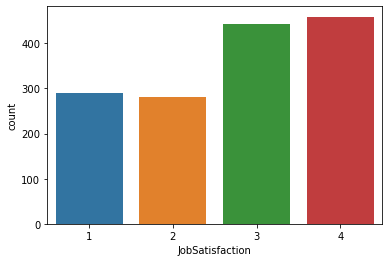

In [35]:
sns.countplot(x=data['JobSatisfaction'])
plt.show()

In [36]:
data[data['JobSatisfaction'] == 1].shape[0] / data.shape[0]

0.19659863945578232

* Несмотря на преобладание высоких оценок удовлетворенности работой (JobSatisfaction), низкие оценки составляют почти 20%. 

Рассмотрим ситуацию для каждого из отделов

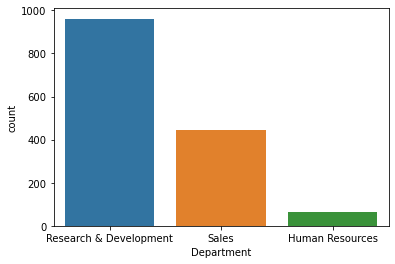

In [37]:
sns.countplot(x=orig_data['Department'])
plt.show()

Так как распределение не является равномерным (в отделах сильно различаются количества сотрудников), то определим долю низких оценок и среднее значение JobSatisfaction в каждом отделе

In [38]:
jobS_dep = dict()
for dep_code in codes['Department'].keys():
    jobS_dep[codes['Department'][dep_code]] = [data[(data['Department'] == dep_code) & (data['JobSatisfaction'] == 1)].shape[0] / data[data['Department'] == dep_code].shape[0],
        data[data['Department'] == dep_code]['JobSatisfaction'].mean()]
pd.DataFrame.from_dict(jobS_dep, orient='index', columns=['Proportion of "Low"', 'Mean'])

,"Proportion of ""Low""",Mean
Human Resources,0.174603,2.603175
Research & Development,0.199792,2.726327
Sales,0.192825,2.751121


* Таким образом, доли низких оценок и средние значения удовлетворенности работой в разных отделах примерно одинаковы

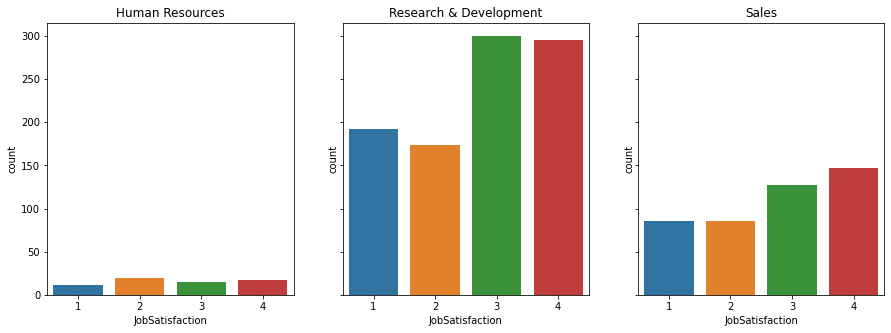

In [39]:
grid, axes = plt.subplots(1, len(codes['Department'].keys()), figsize=(15, 5), sharey=True)
for dep_code in codes['Department'].keys():
    sns.countplot(ax=axes[dep_code], x=data[data['Department'] == dep_code]['JobSatisfaction'])
    axes[dep_code].set_title(codes['Department'][dep_code])
plt.show()

Рассмотрим данный аспект также в рамках разных уровней должности (JobLevel)

In [40]:
data['JobLevel'].unique()

array([2, 3, 1, 4, 5], dtype=int64)

In [41]:
jobS_lev = dict()
for level in data['JobLevel'].unique():
    jobS_lev[level] = [data[(data['JobLevel'] == level) & (data['JobSatisfaction'] == 1)].shape[0] / data[data['JobLevel'] == level].shape[0],
        data[data['JobLevel'] == level]['JobSatisfaction'].mean()]
pd.DataFrame.from_dict(jobS_lev, orient='index', columns=['Proportion of "Low"', 'Mean']).sort_index()

,"Proportion of ""Low""",Mean
1,0.195212,2.718232
2,0.191011,2.758427
3,0.229358,2.678899
4,0.198113,2.726415
5,0.144928,2.739130


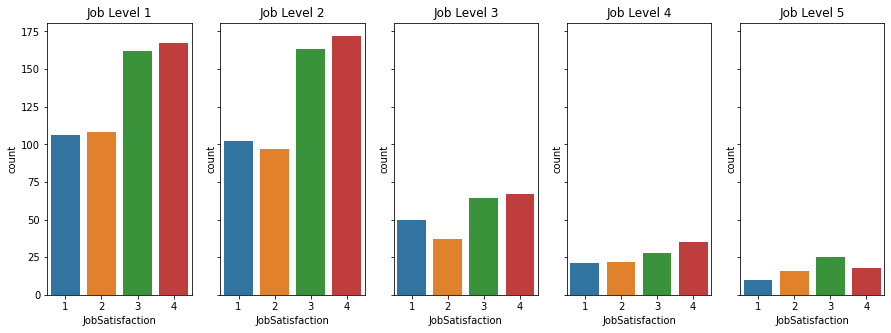

In [42]:
grid, axes = plt.subplots(1, data['JobLevel'].nunique(), figsize=(15, 5), sharey=True)
for jLevel in data['JobLevel'].unique():
    sns.countplot(ax=axes[jLevel-1], x=data[data['JobLevel'] == jLevel]['JobSatisfaction'])
    axes[jLevel-1].set_title('Job Level ' + str(jLevel))
plt.show()

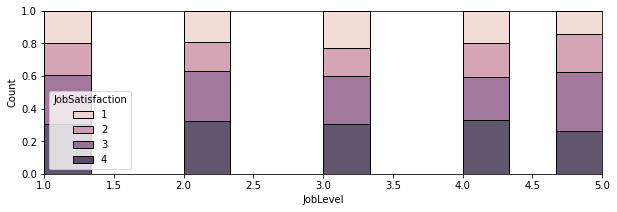

In [43]:
plt.figure(figsize=(10, 3))
sns.histplot(data=data,x = data['JobLevel'], hue="JobSatisfaction", multiple="fill")
plt.show()

* Заметно, что доля неудовлетворенных работой наибольшая среди сотрудников с JobLevel = 3 и составляет примерно 23%
* Для сотрудников с JobLevel = 5 доля неудовлетворенных составляет лишь 14.5%

## Анализ факторов, влияющих на выгорание (Attrition)

### Анализ корреляций и графиков зависимостей

Рассмотрим все корреляции факторов с фактором истощения (Attrition) с коэффициентом больше 0.15 по модулю

In [44]:
cor[cor['Attrition'].abs() > 0.15]['Attrition'].round(3)

Age                    -0.159
Attrition               1.000
JobLevel               -0.169
MaritalStatus           0.162
MonthlyIncome          -0.160
OverTime                0.246
TotalWorkingYears      -0.171
YearsInCurrentRole     -0.161
YearsWithCurrManager   -0.156
Name: Attrition, dtype: float64

Рассмотрим графики распределения сотрудников по разным факторам с наличием истощения и без

Особое внимание уделим коррелирующим факторам

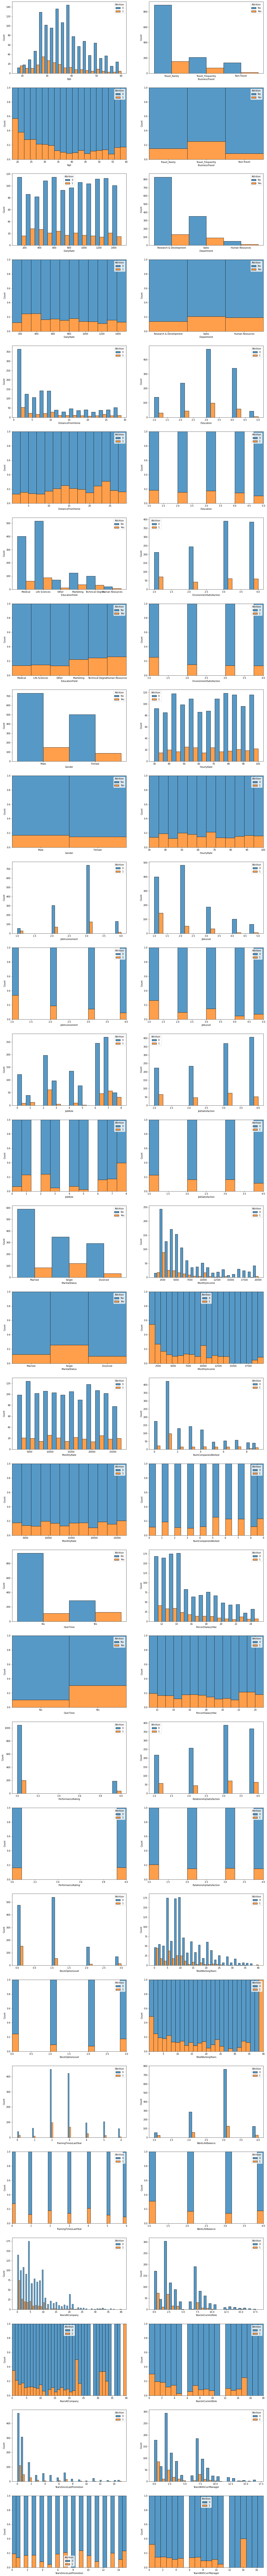

In [45]:
grid, axes = plt.subplots(30, 2, figsize=(20, 210))
for num, col in enumerate(data.drop('Attrition', axis=1).columns):
    plot_df = data if col not in codes or col=='JobRole' else orig_data
    sns.histplot(ax = axes[num-int(num%2)][int(num%2)], data=plot_df, x=col, hue="Attrition", multiple="dodge")
    sns.histplot(ax = axes[num-int(num%2)+1][int(num%2)], data=plot_df, x=col, hue="Attrition", multiple="fill")
plt.show()

Сделаем выводы исходя из графиков

Отрицательно коррелирующие факторы:
* Age - среди молодых сотрудников доля истощенных заметно больше
* JobLevel - среди сотрудников с низким уровнем должности доля истощенных несильно больше
* MonthlyIncome - при уменьшении месячного дохода доля истощенных сотрудников возрастает (также есть резкий скачок при среднем месячном доходе)
* TotalWorkingYears - доля истощенных сотрудников наибольшая среди сотрудников с наименьшим опытом (в силу малого количества сотрудников с большим опытом нельзя сделать вывод о закономерности среди них)
* YearsInCurrentRole - доля истощенных сотрудников наибольшая среди сотрудников, проработавших на текущей позиции меньше 2.5 лет (в силу малого количества сотрудников, проработавших дольше 14 лет, нельзя сделать вывод о закономерности среди них)
* YearsWithCurrManager - ситуация аналогична с YearsInCurrentRole

YearsInCurrentRole и YearsWithCurrManager являются сильно коррелирующими друг с другом факторами, исходя из матрицы корреляций, поэтому такая ситуация неудивительна. 

*Среди этих факторов имеется взамосвязь, обусловленная опытом сотрудников. То есть, чем старше сотрудник, тем он опытнее, а значит занимает должность большего уровня, а значит и его месячный доход выше. При этом возраст сотрудника также сильно коррелирует с его рабочим стажем (TotalWorkingYears), причем последний сильно коррелирует со стажем в компании (YearsAtCompany), а чем дольше сотрудник работает, тем он дольше остается на конкретной должности (вероятно, либо не идет на повышениие, либо занимает уже высокую должность). Ситуация с начальством аналогична.*

Положительно коррелирующие факторы:
* OverTime - у перерабатывающих сотрудников доля истощенных выше
* MaritalStatus - доля истощенных выше у неженатых/незамужних, у остальных она примерно одинакова

*Первый фактор вполне логичен, а второй является неожиданным, так как доля истощенных при разных оценках удовлетворенности отношениями одинакова.*

Зависимости выявленные из графиков:
* BusinessTravel - доля истощенных сотрудников наибольшая среди часто отправляющихся в командировки, при этом при уменьшении частоты - уменьшается и доля истощенных
* EnvironmentSatisfaction - при низкой удовлетворенности окружением наблюдается наибольшая доля истощенных сотрудников
* WorkLifeBalance - при плохом соблюдении баланса жизни и работы наблюдается небольшой рост доли истощенных сотрудников
* JobRole - истощение сотрудников также сильно зависит от позиции, которую они занимают
* StockOptionLevel - доля истощенных выше среди сотрудников с наименьшим и наибольшим уровнями опциона эмитента
* JobSatisfaction - при увеличении уровня удовлетворенности работой доля истощенных сотрудников падает
* JobInvolvement - при увеличении степени вовлеченности в работу доля истощенных сотрудников также падает

Составим перечень выявленных ключевых факторов

In [46]:
factors = [ 
    'Age', 
    'JobLevel', 
    'MonthlyIncome', 
    'TotalWorkingYears', 
    'YearsInCurrentRole', 
    'YearsWithCurrManager', 
    'OverTime',
    'MaritalStatus',
    'BusinessTravel',
    'EnvironmentSatisfaction',
    'WorkLifeBalance',
    'JobRole',
    'StockOptionLevel',
    'JobSatisfaction',
    'JobInvolvement',
]

### Реализация моделей машинного обучения для предсказания фактора истощения сотрудников

Так как истощенные сотрудники составляют всего 16% от общего числа сотрудников, то необходимо сбалансировать классы. В свою очередь выборка не столь большая, поэтому нельзя сократить примеры мажоритарного класса и необходимо увеличить примеры миноритарного класса. Для этого прибегнем к алгоритму ADASYN

In [47]:
x = data[factors].to_numpy()
y = data['Attrition'].to_numpy()
x, y = ADASYN().fit_sample(x, y)

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=101, stratify=y)

#### Logistic Regression with scaling

In [49]:
lr_model = LogisticRegression(random_state=101, max_iter=500)
ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train)
x_test_scaled = ss.transform(x_test)
lr_model.fit(x_train_scaled, y_train)

LogisticRegression(max_iter=500, random_state=101)

In [50]:
y_train_pr = lr_model.predict(x_train_scaled)
y_test_pr  = lr_model.predict(x_test_scaled)

In [51]:
print(metrics.classification_report(y_test, y_test_pr))
accur_lr = metrics.accuracy_score(y_test, y_test_pr)
auc_roc_lr = metrics.roc_auc_score(y_test, lr_model.predict_proba(x_test_scaled)[:,1])
print('AUC ROC', auc_roc_lr)

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       308
           1       0.80      0.81      0.81       298

    accuracy                           0.81       606
   macro avg       0.81      0.81      0.81       606
weighted avg       0.81      0.81      0.81       606

AUC ROC 0.8798265492896364


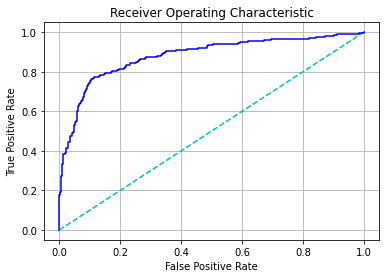

In [52]:
fpr_lr, tpr_lr, thresholds = metrics.roc_curve(y_test, lr_model.predict_proba(x_test_scaled)[:,1])
plt.grid()
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1], 'c--')
plt.plot(fpr_lr, tpr_lr, 'b')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forest

In [53]:
rf_model = RandomForestClassifier(random_state=101, n_estimators=100, min_samples_leaf=2, bootstrap=False)
rf_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=2, random_state=101)

In [54]:
y_train_pr = rf_model.predict(x_train)
y_test_pr  = rf_model.predict(x_test)

In [55]:
print(metrics.classification_report(y_test, y_test_pr))
accur_rf = metrics.accuracy_score(y_test, y_test_pr)
auc_roc_rf = metrics.roc_auc_score(y_test, rf_model.predict_proba(x_test)[:,1])
print('AUC ROC', auc_roc_rf)

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       308
           1       0.92      0.89      0.90       298

    accuracy                           0.91       606
   macro avg       0.91      0.91      0.91       606
weighted avg       0.91      0.91      0.91       606

AUC ROC 0.9676305238385775


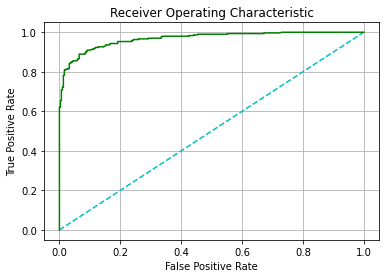

In [56]:
fpr_rf, tpr_rf, thresholds = metrics.roc_curve(y_test, rf_model.predict_proba(x_test)[:,1])
plt.grid()
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'c--')
plt.plot(fpr_rf, tpr_rf, 'g')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Catboost

In [57]:
catb_model = catb.CatBoostClassifier(random_state=101)
catb_model.fit(x_train, y_train)

Learning rate set to 0.013298
0:	learn: 0.6861208	total: 148ms	remaining: 2m 27s
1:	learn: 0.6787695	total: 152ms	remaining: 1m 15s
2:	learn: 0.6720769	total: 155ms	remaining: 51.4s
3:	learn: 0.6658948	total: 158ms	remaining: 39.3s
4:	learn: 0.6599780	total: 161ms	remaining: 32s
5:	learn: 0.6531032	total: 164ms	remaining: 27.2s
6:	learn: 0.6475033	total: 167ms	remaining: 23.7s
7:	learn: 0.6420774	total: 170ms	remaining: 21.1s
8:	learn: 0.6355566	total: 173ms	remaining: 19.1s
9:	learn: 0.6294828	total: 177ms	remaining: 17.5s
10:	learn: 0.6252712	total: 180ms	remaining: 16.1s
11:	learn: 0.6196225	total: 182ms	remaining: 15s
12:	learn: 0.6146569	total: 184ms	remaining: 14s
13:	learn: 0.6097543	total: 187ms	remaining: 13.2s
14:	learn: 0.6051952	total: 189ms	remaining: 12.4s
15:	learn: 0.5997974	total: 191ms	remaining: 11.8s
16:	learn: 0.5952061	total: 193ms	remaining: 11.2s
17:	learn: 0.5905296	total: 195ms	remaining: 10.7s
18:	learn: 0.5859868	total: 198ms	remaining: 10.2s
19:	learn: 0.58

179:	learn: 0.3406966	total: 530ms	remaining: 2.42s
180:	learn: 0.3398227	total: 533ms	remaining: 2.41s
181:	learn: 0.3392872	total: 535ms	remaining: 2.4s
182:	learn: 0.3386113	total: 537ms	remaining: 2.4s
183:	learn: 0.3379401	total: 539ms	remaining: 2.39s
184:	learn: 0.3372509	total: 542ms	remaining: 2.39s
185:	learn: 0.3367361	total: 544ms	remaining: 2.38s
186:	learn: 0.3362871	total: 546ms	remaining: 2.37s
187:	learn: 0.3355783	total: 549ms	remaining: 2.37s
188:	learn: 0.3349528	total: 551ms	remaining: 2.37s
189:	learn: 0.3343831	total: 554ms	remaining: 2.36s
190:	learn: 0.3338931	total: 556ms	remaining: 2.35s
191:	learn: 0.3330640	total: 558ms	remaining: 2.35s
192:	learn: 0.3324431	total: 560ms	remaining: 2.34s
193:	learn: 0.3317693	total: 562ms	remaining: 2.33s
194:	learn: 0.3311275	total: 565ms	remaining: 2.33s
195:	learn: 0.3307346	total: 567ms	remaining: 2.32s
196:	learn: 0.3301098	total: 569ms	remaining: 2.32s
197:	learn: 0.3292996	total: 571ms	remaining: 2.31s
198:	learn: 0.

347:	learn: 0.2654935	total: 883ms	remaining: 1.65s
348:	learn: 0.2649163	total: 885ms	remaining: 1.65s
349:	learn: 0.2645409	total: 888ms	remaining: 1.65s
350:	learn: 0.2642192	total: 890ms	remaining: 1.65s
351:	learn: 0.2640118	total: 892ms	remaining: 1.64s
352:	learn: 0.2638508	total: 894ms	remaining: 1.64s
353:	learn: 0.2633424	total: 897ms	remaining: 1.64s
354:	learn: 0.2629663	total: 899ms	remaining: 1.63s
355:	learn: 0.2625839	total: 901ms	remaining: 1.63s
356:	learn: 0.2623415	total: 903ms	remaining: 1.63s
357:	learn: 0.2620123	total: 905ms	remaining: 1.62s
358:	learn: 0.2618027	total: 907ms	remaining: 1.62s
359:	learn: 0.2613418	total: 909ms	remaining: 1.62s
360:	learn: 0.2610383	total: 911ms	remaining: 1.61s
361:	learn: 0.2607050	total: 913ms	remaining: 1.61s
362:	learn: 0.2605045	total: 915ms	remaining: 1.61s
363:	learn: 0.2601893	total: 918ms	remaining: 1.6s
364:	learn: 0.2599700	total: 920ms	remaining: 1.6s
365:	learn: 0.2596814	total: 922ms	remaining: 1.6s
366:	learn: 0.2

515:	learn: 0.2184774	total: 1.24s	remaining: 1.16s
516:	learn: 0.2180881	total: 1.24s	remaining: 1.16s
517:	learn: 0.2178816	total: 1.24s	remaining: 1.16s
518:	learn: 0.2174312	total: 1.24s	remaining: 1.15s
519:	learn: 0.2170774	total: 1.25s	remaining: 1.15s
520:	learn: 0.2169246	total: 1.25s	remaining: 1.15s
521:	learn: 0.2165206	total: 1.25s	remaining: 1.15s
522:	learn: 0.2163696	total: 1.25s	remaining: 1.14s
523:	learn: 0.2161508	total: 1.25s	remaining: 1.14s
524:	learn: 0.2159781	total: 1.26s	remaining: 1.14s
525:	learn: 0.2155519	total: 1.26s	remaining: 1.14s
526:	learn: 0.2154482	total: 1.26s	remaining: 1.13s
527:	learn: 0.2151339	total: 1.26s	remaining: 1.13s
528:	learn: 0.2149628	total: 1.26s	remaining: 1.13s
529:	learn: 0.2147190	total: 1.27s	remaining: 1.12s
530:	learn: 0.2144865	total: 1.27s	remaining: 1.12s
531:	learn: 0.2142122	total: 1.27s	remaining: 1.12s
532:	learn: 0.2139563	total: 1.27s	remaining: 1.12s
533:	learn: 0.2137553	total: 1.28s	remaining: 1.11s
534:	learn: 

684:	learn: 0.1799543	total: 1.59s	remaining: 730ms
685:	learn: 0.1798242	total: 1.59s	remaining: 728ms
686:	learn: 0.1796944	total: 1.59s	remaining: 726ms
687:	learn: 0.1794362	total: 1.59s	remaining: 723ms
688:	learn: 0.1792062	total: 1.6s	remaining: 721ms
689:	learn: 0.1789081	total: 1.6s	remaining: 719ms
690:	learn: 0.1785415	total: 1.6s	remaining: 716ms
691:	learn: 0.1784363	total: 1.6s	remaining: 714ms
692:	learn: 0.1782851	total: 1.61s	remaining: 711ms
693:	learn: 0.1780309	total: 1.61s	remaining: 709ms
694:	learn: 0.1778512	total: 1.61s	remaining: 707ms
695:	learn: 0.1777109	total: 1.61s	remaining: 704ms
696:	learn: 0.1775359	total: 1.61s	remaining: 702ms
697:	learn: 0.1774298	total: 1.62s	remaining: 699ms
698:	learn: 0.1772780	total: 1.62s	remaining: 697ms
699:	learn: 0.1771145	total: 1.62s	remaining: 694ms
700:	learn: 0.1770195	total: 1.62s	remaining: 692ms
701:	learn: 0.1769493	total: 1.62s	remaining: 690ms
702:	learn: 0.1768506	total: 1.63s	remaining: 687ms
703:	learn: 0.17

855:	learn: 0.1482880	total: 1.94s	remaining: 327ms
856:	learn: 0.1479996	total: 1.94s	remaining: 324ms
857:	learn: 0.1477352	total: 1.95s	remaining: 322ms
858:	learn: 0.1474859	total: 1.95s	remaining: 320ms
859:	learn: 0.1472928	total: 1.95s	remaining: 318ms
860:	learn: 0.1471247	total: 1.95s	remaining: 315ms
861:	learn: 0.1469990	total: 1.96s	remaining: 313ms
862:	learn: 0.1469135	total: 1.96s	remaining: 311ms
863:	learn: 0.1467732	total: 1.96s	remaining: 308ms
864:	learn: 0.1465719	total: 1.96s	remaining: 306ms
865:	learn: 0.1464484	total: 1.96s	remaining: 304ms
866:	learn: 0.1463328	total: 1.97s	remaining: 302ms
867:	learn: 0.1461207	total: 1.97s	remaining: 299ms
868:	learn: 0.1459995	total: 1.97s	remaining: 297ms
869:	learn: 0.1458178	total: 1.97s	remaining: 295ms
870:	learn: 0.1457129	total: 1.97s	remaining: 292ms
871:	learn: 0.1454636	total: 1.98s	remaining: 290ms
872:	learn: 0.1453391	total: 1.98s	remaining: 288ms
873:	learn: 0.1452043	total: 1.98s	remaining: 286ms
874:	learn: 

In [58]:
y_train_pr = catb_model.predict(x_train)
y_test_pr  = catb_model.predict(x_test)

In [59]:
print(metrics.classification_report(y_test, y_test_pr))
accur_cb = metrics.accuracy_score(y_test, y_test_pr)
auc_roc_cb = metrics.roc_auc_score(y_test, catb_model.predict_proba(x_test)[:,1])
print('AUC ROC', auc_roc_cb)

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       308
           1       0.91      0.90      0.90       298

    accuracy                           0.90       606
   macro avg       0.90      0.90      0.90       606
weighted avg       0.90      0.90      0.90       606

AUC ROC 0.9614093959731543


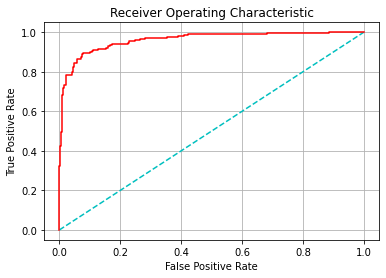

In [60]:
fpr_cb, tpr_cb, thresholds = metrics.roc_curve(y_test, catb_model.predict_proba(x_test)[:,1])
plt.grid()
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1], 'c--')
plt.plot(fpr_cb, tpr_cb, 'r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Сравнение ROC-кривых

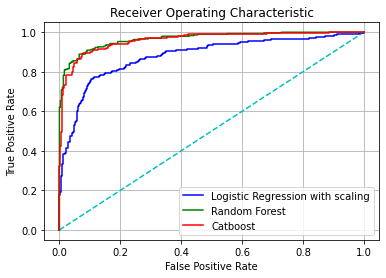

,AUC ROC,accuracy
Logistic Regression with scaling,0.879827,0.808581
Random Forest,0.967631,0.907591
Catboost,0.961409,0.904290


In [61]:
lr_name = 'Logistic Regression with scaling'
rf_name = 'Random Forest'
cb_name = 'Catboost'
plt.grid()
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'c--')
plt.plot(fpr_lr, tpr_lr, 'b', label = lr_name)
plt.plot(fpr_rf, tpr_rf, 'g', label = rf_name)
plt.plot(fpr_cb, tpr_cb, 'r', label = cb_name)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()
pd.DataFrame([{
    lr_name : auc_roc_lr, 
    rf_name : auc_roc_rf, 
    cb_name : auc_roc_cb
    },{
    lr_name : accur_lr, 
    rf_name : accur_rf, 
    cb_name : accur_cb
    }],
    index=['AUC ROC','accuracy']).transpose()

#### Вывод

Было реализовано 3 модели:
* Logistic Regression with scaling
* Random Forest
* Catboost

Первая показала себя немного хуже двух остальных, которые в свою очередь показали приблизительно одинаковые метрики качества.

Однако у всех моделей достаточно высокие результаты AUC ROC, что говорит о том, что ключевые факторы, приводящие к истощению сотрудников выбраны верно.